In [103]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

In [ ]:
# Create a VideoCapture object and read from input file
# If the input is the camera, pass 0 instead of the video file name
cap = cv2.VideoCapture('VID_20200531_230307.mp4')

# Check if camera opened successfully
if (cap.isOpened()== False): 
  print("Error opening video stream or file")

# Read until video is completed
frn=0
ct=0
while(cap.isOpened()):
  # Capture frame-by-frame
  ret, frame = cap.read()
  if ret == True:
    if ct%4==0:
        cv2.imwrite('vids/1/{}.png'.format(str(frn).zfill(3)),frame)
        frn+=1
        print('Written to vids/1/{}.png'.format(str(frn).zfill(3)))
    ct+=1
  # Break the loop
  else: 
    break

# When everything done, release the video capture object
cap.release()

In [41]:
#turns images into squares
for folder in Path('vids').iterdir():
    if 's' not in str(folder.name):
        new_folder=Path(str(folder)+'/unsorted')
        new_folder.mkdir(parents=True,exist_ok=True)
        for file in folder.iterdir():
            if file.is_file(): 
                #print(file)
                img=plt.imread(str(file))
                if img.dtype==np.float32: img=(img*255).astype(np.uint8)
                if img.shape[0]>img.shape[1]:
                    d=int((img.shape[0]-img.shape[1])/2)
                    img_new=img[d:-d-1]
                else:
                    d=int((img.shape[1]-img.shape[0])/2)
                    img_new=img[:,d:-d-1]
                Image.fromarray(img_new).save(str(new_folder)+'/'+file.name)

In [42]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import ResNet50V2, VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [43]:
model=load_model('models/model_{}_tuned_long.h5'.format('Resnet50V2_sqr_no_hidden'))

image_generator=ImageDataGenerator(rescale=1./255)
img_gen_0=image_generator.flow_from_directory(
        directory='vids/0',
        batch_size=32,
        shuffle=False,
        target_size=(224,224)
    )
img_gen_1=image_generator.flow_from_directory(
        directory='vids/1',
        batch_size=32,
        shuffle=False,
        target_size=(224,224)
    )

Found 214 images belonging to 1 classes.
Found 214 images belonging to 1 classes.


In [44]:
pred_0=np.argmax(model.predict(img_gen_0),axis=1)
pred_1=np.argmax(model.predict(img_gen_1),axis=1)

In [52]:
df_preds=pd.DataFrame({'v0':pred_0,'v1':pred_1})

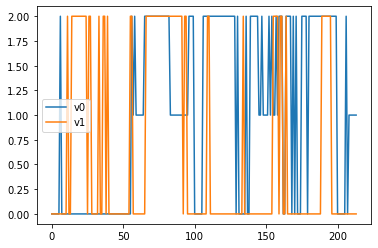

In [53]:
df_preds.plot()

In [97]:
cat_pts={
    0:1.0, #Engaged
    1:0.5, #Looking away
    2:0.2, #Eyes closed
    3:0.0  #Absent
}
cat_names={
    0:"Engaged",
    1:"Looking Away",
    2:"Eyes Closed",
    3:"Absent"
}
pts0=np.full(15,np.nan)
pts1=np.full(15,np.nan)

def write_text(img,text,coord):
    cv2.putText(img,text, 
        coord, 
        cv2.FONT_HERSHEY_SIMPLEX, 
        5,
        (255,0,255),
        15)

for i in df_preds.index:
    cat0,cat1=df_preds.loc[i]
    pts0[i%15]=cat_pts[cat0]
    pts1[i%15]=cat_pts[cat1]
    
    img0=cv2.imread('vids/0/{}.png'.format(str(i).zfill(3)))
    write_text(img0,cat_names[cat0],(30,150))
    write_text(img0,"S: %.2f"%pts0[~np.isnan(pts0)].mean(),(30,300))
    img1=cv2.imread('vids/1/{}.png'.format(str(i).zfill(3)))
    write_text(img1,"S: %.2f"%pts1[~np.isnan(pts1)].mean(),(30,300))
    write_text(img1,cat_names[cat1],(30,150))
    img_spl=np.concatenate([img0,img1],axis=0)
    img_spl = cv2.resize(img_spl, (0,0), fx=0.25, fy=0.25) 
    cv2.imwrite('results/{}.png'.format(str(i).zfill(3)),img_spl)

In [104]:
import os

image_folder = 'results'
video_name = 'video.mp4'

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 15, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()